# Lab 5 - Neural Networks
## Nick Bias
### 5/9/22
## Goal: Predict Income
### Libraries 

In [1]:
import pandas as pd
import numpy as np

# For Neural Networks 
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

# For Grid Search Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# For Standarization 
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# For Boosting 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# For Comparision Models
# compare standalone models for binary classification
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# For splitting data into training and testing 
from sklearn.model_selection import train_test_split
# example of calculate the mean absolute error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# For Evaluations 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# So results are same when re-run
import random
random.seed(10)

## Read In Data

In [2]:
income = pd.read_csv("Data/Week6/income_evaluation.csv", header=None, skiprows=1, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'])
income

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


There are many categorical variables with many different levels. For easier Analyse these will be converted to dummy variables. 

In [3]:
income["income"].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

The target variable we are trying to predict only has two levels. This means this is a binary classification problem. This will be replaced with a dummy variable to check for '>50k'. If income is greater than $50,000, it will be marked with a 1. If it is less than or equal it will be marked with a 0. About 25 percent of the data make more than 50,000 a year. Because of this I do not believe undersampling is required.

## Data Cleaning

In [4]:
# Creates Dummy Varialbes attatched to the dataset and drops old variables 
dummies = pd.get_dummies(income,columns=['income', 'race', 'sex', 'education', 'workclass', 'marital-status', 'occupation', 'relationship', 'native-country'],drop_first=True)

# Drop Education variable as there is another variable that tells the same thing
income_data = dummies.drop(['education-num'], axis = 1)
income_data

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,income_ >50K,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,2174,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,0,0,38,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,0,0,40,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,0,0,20,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [5]:
income_data.columns

Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week',
       'income_ >50K', 'race_ Asian-Pac-Islander', 'race_ Black',
       'race_ Other', 'race_ White', 'sex_ Male', 'education_ 11th',
       'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th',
       'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm',
       'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate',
       'education_ HS-grad', 'education_ Masters', 'education_ Preschool',
       'education_ Prof-school', 'education_ Some-college',
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separa

### Splitting Prediction Variable from dataset
- X = Dataset with all Independent Variables 
- y = The Dependent Variable of Income Bracket

In [6]:
# Only Takes Dependent Variable we are tryng to predict 
y = income_data['income_ >50K']

# Takes independent variables that will be used to predict 
X = income_data.loc[:, income_data.columns != 'income_ >50K']

In [7]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', BaggingClassifier(base_estimator=LogisticRegression())))
    #level0.append(('knn', BaggingClassifier(base_estimator=KNeighborsClassifier())))
    level0.append(('tree', BaggingClassifier(base_estimator=DecisionTreeClassifier())))
    level0.append(('forest', BaggingClassifier(base_estimator=RandomForestClassifier())))
    #level0.append(('svm', BaggingClassifier(base_estimator=SVC())))
    level0.append(('bayes', BaggingClassifier(base_estimator=GaussianNB())))
    level0.append(('adaboost', BaggingClassifier(base_estimator=AdaBoostClassifier())))
    level0.append(('gradboost', BaggingClassifier(base_estimator=GradientBoostingClassifier())))
    level0.append(('xgboost', BaggingClassifier(base_estimator=XGBClassifier())))
    level0.append(('nueralNet', BaggingClassifier(base_estimator=MLPClassifier(random_state=1))))
    # define meta learner model
    level1 = DecisionTreeClassifier()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, passthrough = False)
    return model
# passthrough is used for the stacking to take the og dataset instead of just the other model results

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    #models['knn'] = KNeighborsClassifier()
    models['tree'] = DecisionTreeClassifier()
    models['forest'] = RandomForestClassifier()
    #models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['adaboost'] = AdaBoostClassifier()
    models['gradboost'] = GradientBoostingClassifier()
    models['xgboost'] = XGBClassifier()
    models['nueralNet'] = MLPClassifier(random_state=1)
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()

In [ ]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.798 (0.008)
>tree 0.815 (0.006)
>forest 0.855 (0.006)
>bayes 0.795 (0.006)
>adaboost 0.860 (0.006)
>gradboost 0.865 (0.005)
>xgboost 0.872 (0.006)
>nueralNet 0.688 (0.199)


As we can see the Neural Network performed the worst out of all the model. It was the only model to achieve an accuracy under 79%. The best performing model was the XG Boost with an accuracy of 87.2%, which is 18.4% higher than what the neural network got.

XG Boost and Random Forest Models will be used to compare the Neural Network model with. 

# Models 

In [7]:
# Splitting the Dataset into a Training and Testing set 
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [8]:
# This creates a Function that will Evalutate the models, by looking at Accuracy, Recall, Precision and ROC Curve
# This will be helpful in seeing how well the target class is being predicted 
def model_eval(model, X_test, y_test):
    assert len(X_test) == len(y_test), "X_test and y_test are not equal in size."
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[::, 1]
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_pred, y_test))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC: {round(auc, 3)}')
    plt.legend()
    plt.show()

## Baseline Models to Compare with

We will be looking at the:
- Precision or proportion of positive identifications (making over 50k) that are actually correct 
- Recall or proportion of actual positives (making over 50k) that were identified correctly

[[4594  347]
 [ 622  950]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      5216
           1       0.60      0.73      0.66      1297

    accuracy                           0.85      6513
   macro avg       0.77      0.81      0.78      6513
weighted avg       0.86      0.85      0.86      6513



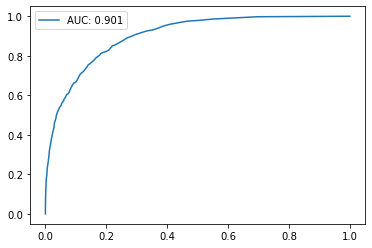

In [10]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
model_eval(forest_model, X_test, y_test)

The default Random Forest model was able to achieve an accuracy of 85%. 73% of actual positive (making over 50K) were identified correctly. however, only 60% of positive identification (making over 50K) were actually correct. The precision and recall are much better for the negative class or making less than or equal 50K, meaning that the model is better at identifying who makes less than or equal to 50K a year, than those that make more.

[[4644  297]
 [ 574  998]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5218
           1       0.63      0.77      0.70      1295

    accuracy                           0.87      6513
   macro avg       0.79      0.83      0.81      6513
weighted avg       0.88      0.87      0.87      6513



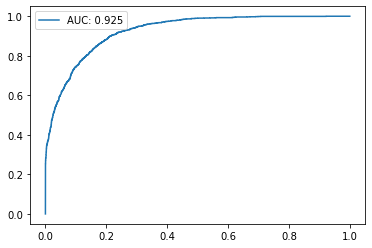

In [11]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
model_eval(xgb_model, X_test, y_test)

The default XG Boost model was able to achieve an accuracy of 87%, which is 3% more accurate than the randome forest. 77% of actual positive (making over 50K) were identified correctly. This is a 5% increase over the Randome Forest. However, only 63% of positive identification (making over 50K) were actually correct. The precision and recall are much better for the negative class or making less than or equal 50K, meaning that the model is better at identifying who makes less than or equal to 50K a year, than those that make more.

[[   6 4935]
 [   0 1572]]
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         6
           1       1.00      0.24      0.39      6507

    accuracy                           0.24      6513
   macro avg       0.50      0.62      0.20      6513
weighted avg       1.00      0.24      0.39      6513



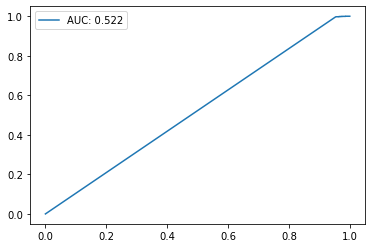

In [12]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)
model_eval(mlp, X_test, y_test)

The default Neural Network performed horribly, with an accuracy of 24%. Its precision for income under 50K is 0%. This is not a good model and will need to be tuned well if it will be used to predict income bracket.

## Tunning

[[4649  324]
 [1017  523]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5666
           1       0.34      0.62      0.44       847

    accuracy                           0.79      6513
   macro avg       0.64      0.72      0.66      6513
weighted avg       0.86      0.79      0.82      6513



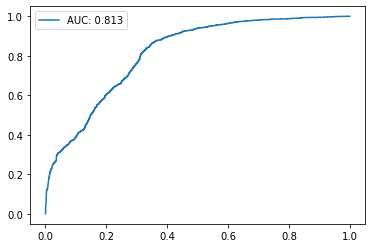

In [10]:
bag = BaggingClassifier(base_estimator=MLPClassifier(random_state=1), random_state=1)
bag.fit(X_train, y_train)
model_eval(bag, X_test, y_test)

Bagging the model seems to hve increased Accuracy drastically. It went up by 55%. This helped much more than I originally thought it would. Precision and recall have also increased a lot. Bagging will be used in the final model. 

[[4875   98]
 [1176  364]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      6051
           1       0.24      0.79      0.36       462

    accuracy                           0.80      6513
   macro avg       0.61      0.80      0.62      6513
weighted avg       0.93      0.80      0.85      6513



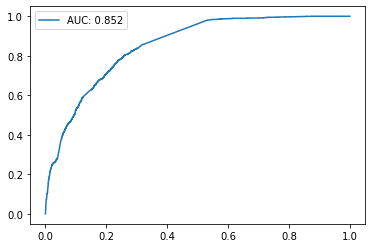

In [14]:
bag = BaggingClassifier(base_estimator=MLPClassifier(random_state=1, 
                                                     activation='identity'), random_state=1)
bag.fit(X_train, y_train)
model_eval(bag, X_test, y_test)

[[4969    4]
 [1482   58]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      6451
           1       0.04      0.94      0.07        62

    accuracy                           0.77      6513
   macro avg       0.52      0.85      0.47      6513
weighted avg       0.99      0.77      0.86      6513



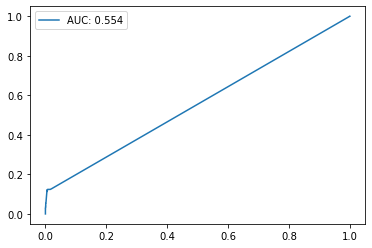

In [15]:
bag = BaggingClassifier(base_estimator=MLPClassifier(random_state=1, 
                                                     activation='identity',
                                                     hidden_layer_sizes(50,50,50)), random_state=1)
bag.fit(X_train, y_train)
model_eval(bag, X_test, y_test)

Models were taking too long to run, so I started using grid search to test multiple models at once.

In [18]:
mlp = MLPClassifier(random_state=1, max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (400,)],
    'activation': ['identity', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (400,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [19]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.758 (+/-0.000) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.787 (+/-0.005) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.758 (+/-0.000) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.787 (+/-0.005) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.758 (+/-0.000) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.801 (+/-0.009) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learnin

In [21]:
y_true, y_pred = y_test , clf.predict(X_test)


print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4973
           1       0.80      0.22      0.35      1540

    accuracy                           0.80      6513
   macro avg       0.80      0.60      0.62      6513
weighted avg       0.80      0.80      0.76      6513



The best performing model was "0.803 (+/-0.005) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate_init': 0.001}". These are the parameters that will be used for the final model. It achieved an accuracy of 80.3%. This is not better than the Randome Forest or XG Boost Models, but it is much better than the default Neural Network we started with. Next I will try to bag the model to see if it will boost performance.

[[4799  174]
 [1122  418]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      5921
           1       0.27      0.71      0.39       592

    accuracy                           0.80      6513
   macro avg       0.62      0.76      0.64      6513
weighted avg       0.90      0.80      0.84      6513



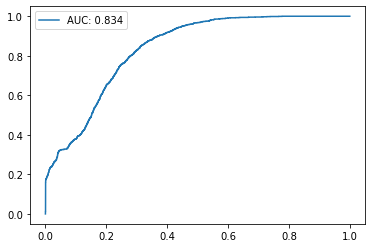

In [26]:
bag = BaggingClassifier(base_estimator=MLPClassifier(random_state=1, 
                                                     solver='adam',
                                                     max_iter=400, 
                                                     activation='identity', 
                                                     learning_rate_init=0.001, 
                                                     hidden_layer_sizes=(50, 100, 50), 
                                                     alpha=0.0001), random_state=1)
bag.fit(X_train, y_train)
model_eval(bag, X_test, y_test)

Bagging did not help model performance much. It slightly increased recall and precision, but not by much.

## Standarization

[[4627  346]
 [ 604  936]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      5231
           1       0.61      0.73      0.66      1282

    accuracy                           0.85      6513
   macro avg       0.77      0.81      0.79      6513
weighted avg       0.87      0.85      0.86      6513



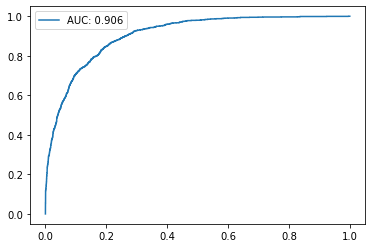

In [31]:
pipe = make_pipeline(StandardScaler(), BaggingClassifier(base_estimator=MLPClassifier(random_state=1, 
                                                     solver='adam',
                                                     max_iter=400, 
                                                     activation='identity', 
                                                     learning_rate_init=0.001, 
                                                     hidden_layer_sizes=(50, 100, 50), 
                                                     alpha=0.0001), random_state=1))
pipe.fit(X_train, y_train)
model_eval(pipe, X_test, y_test)

As we can see Standardization has boosted model accuracy by 5%. This is not a major increase, but it is still performing better than before. However, this accuracy is what the default Random Forest was able to achieve without any tuning. The default XG Boost model was able to get ana accuracy of 87%, which is 2% better than the tuned Nueral Network. 

This Neural Network has three layer 50 nodes in the first and last layers, and 100 nodes in the middle layer. It has a identity activation function, which means no-op activation, useful to implement linear bottleneck, returns f(x) = x. It uses the ‘adam’ solver, which refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba. 
Overall, this is a good performing model, there are just other, better models that can be used to predict income. 